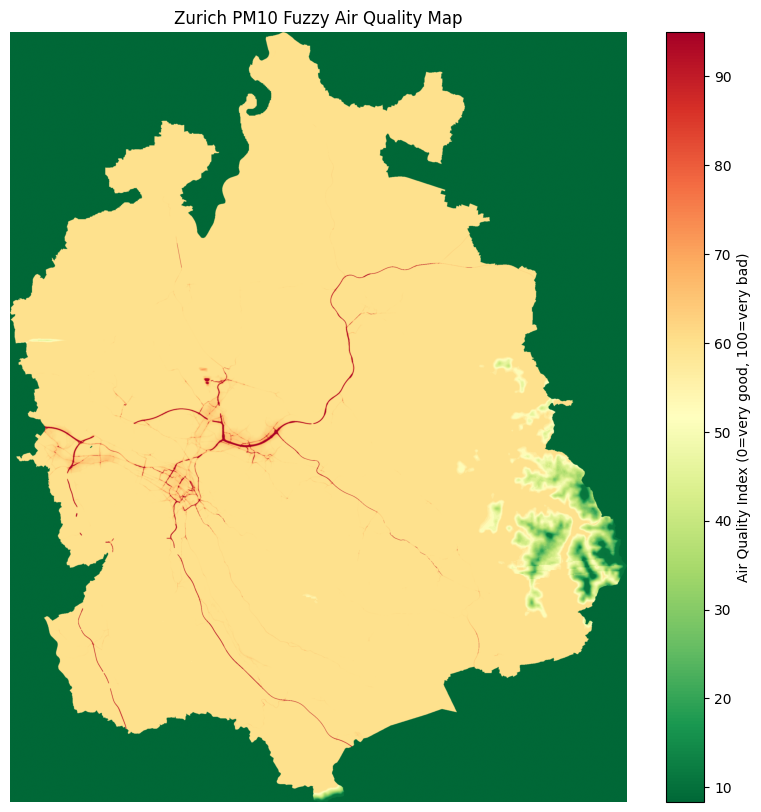

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# --- LOAD THE TIFF FILE ---
input_file = "../geoserver_data/data/pm10.tif"
output_file = "../geoserver_data/data/zurich_fuzzy_quality.tif"

with rasterio.open(input_file) as src:
    data = src.read(1).astype(float)
    meta = src.meta.copy()  # preserve geospatial info

# --- DEFINE FUZZY VARIABLE (adjusted for max value 351) ---
pm10 = ctrl.Antecedent(np.linspace(0, 400, 401), 'pm10')  # PM10 from 0 to 400
pm10['good'] = fuzz.trimf(pm10.universe, [0, 0, 100])
pm10['moderate'] = fuzz.trimf(pm10.universe, [80, 150, 180])
pm10['bad'] = fuzz.trimf(pm10.universe, [150, 300, 400])

quality = ctrl.Consequent(np.linspace(0, 100, 101), 'quality')
quality['very_good'] = fuzz.trimf(quality.universe, [0, 0, 25])
quality['good'] = fuzz.trimf(quality.universe, [20, 40, 60])
quality['liveable'] = fuzz.trimf(quality.universe, [50, 60, 70])
quality['bad'] = fuzz.trimf(quality.universe, [65, 80, 90])
quality['very_bad'] = fuzz.trimf(quality.universe, [85, 100, 100])

# --- DEFINE RULES ---
rules = [
    ctrl.Rule(pm10['good'], quality['very_good']),
    ctrl.Rule(pm10['moderate'], quality['liveable']),
    ctrl.Rule(pm10['bad'], quality['very_bad']),
]

quality_ctrl = ctrl.ControlSystem(rules)
quality_sim = ctrl.ControlSystemSimulation(quality_ctrl)

# --- APPLY FUZZY SYSTEM PIXEL-WISE ---
fuzzy_map = np.zeros_like(data, dtype=float)

# Flatten data for faster computation
flat_data = data.flatten()
flat_result = np.zeros_like(flat_data, dtype=float)

for i, val in enumerate(flat_data):
    quality_sim.input['pm10'] = val
    quality_sim.compute()
    flat_result[i] = quality_sim.output['quality']

fuzzy_map = flat_result.reshape(data.shape)

# --- SAVE AS TIF ---
meta.update(dtype=rasterio.float32, count=1)
with rasterio.open(output_file, 'w', **meta) as dst:
    dst.write(fuzzy_map.astype(rasterio.float32), 1)

# --- PLOT FUZZY MAP ---
plt.figure(figsize=(10, 10))
plt.imshow(fuzzy_map, cmap='RdYlGn_r')  # red=bad, green=good
plt.colorbar(label='Air Quality Index (0=very good, 100=very bad)')
plt.title("Zurich PM10 Fuzzy Air Quality Map")
plt.axis("off")
plt.show()
